In [5]:
%reset

In [6]:
from keras.utils import img_to_array, load_img
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage.transform import resize
from IPython.display import Image as imgdisp, display
from keras.models import load_model
from clear_folder import clear_folder
import keras
import logging
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)

# Define the paths to the folders and the weights file
effected_folder = '/home/abidhasan/Documents/Indicate_FH/data/effected'
not_effected_folder = '/home/abidhasan/Documents/Indicate_FH/data/not_effected'
weights_path = '/home/abidhasan/Documents/Indicate_FH/saved_model/vgg16_300.h5'

# Image Size
size = 299
n_channels = 3
model_name = 'xception'
# Function to preprocess images
affected_img1 = "/home/abidhasan/Documents/Indicate_FH/train_val_test/test/effected/001_CLE204_Baseline_111.png"
affected_img2 = "/home/abidhasan/Documents/Indicate_FH/data/effected/001_CLE114_Baseline_112.png"
affected_img3 = "/home/abidhasan/Documents/Indicate_FH/data/effected/007_CLE203_Weizen_114.png"
affected_img4 = "/home/abidhasan/Documents/Indicate_FH/data/effected/CLE101_Baseline_Reaktion_CLE101_Baseline_Reaktion_3.png"
non_affected_img = "/home/abidhasan/Documents/Indicate_FH/train_val_test/test/not_effected/001_CLE197_Baseline_4.png"

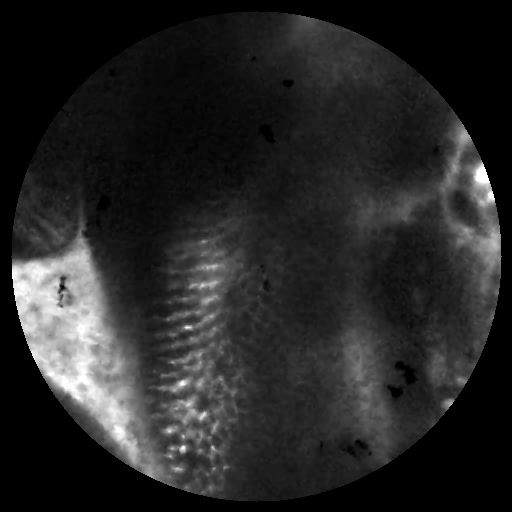

In [7]:
display(imgdisp(affected_img1))

In [8]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [9]:
model = load_model('/home/abidhasan/Documents/Indicate_FH/saved_model/xception_100.h5')
model.summary()

2024-06-07 21:26:59.644580: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8B (rounded to 256)requested by op SameWorkerRecvDone
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-06-07 21:26:59.644638: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-06-07 21:26:59.644651: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 69, Chunks in use: 69. 17.2KiB allocated for chunks. 17.2KiB in use in bin. 3.7KiB client-requested in use in bin.
2024-06-07 21:26:59.644657: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 24, Chunks in use: 24. 12.2KiB allocated for chunks. 12.2KiB in use in bin. 12.0KiB client-requested in use in bin.
2024-06-07 21:26:59.644661: I tensorflow/tsl/framework/

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomGetKeyCounter_device_/job:localhost/replica:0/task:0/device:GPU:0}} SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:GPU:0;0e2bb6c49c7c15c1;/job:localhost/replica:0/task:0/device:GPU:0;edge_3_StatelessRandomGetKeyCounter;0:0
	 [[{{node StatelessRandomGetKeyCounter/_4}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:StatelessRandomGetKeyCounter]

In [ ]:
last_conv_layer_name = "block14_sepconv2_act"

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
img_array = get_img_array(affected_img3, size=(size, size))

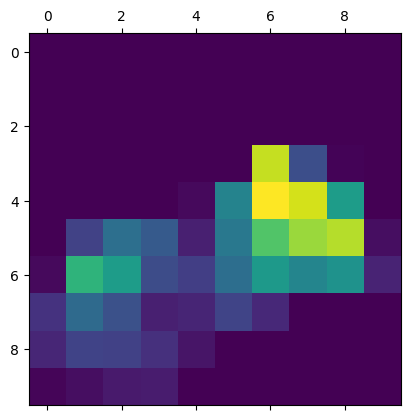

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Image shape (510, 512, 3)
Image Max Pixel value: 255.0
Shape of Jet_heatmap: (510, 512, 3)
Jet Heatmap Max Pixel value: 255.0


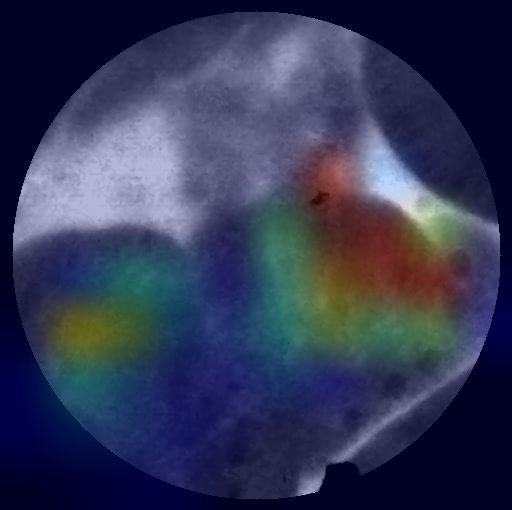

In [ ]:
from IPython.display import Image, display
model_name='xception'
import matplotlib as mpl


def save_and_display_gradcam(img_path, heatmap, cam_path="/home/abidhasan/Documents/Indicate_FH/grad_cam_images/effected_img1.png", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    print("Image shape {}".format(img.shape))
    print("Image Max Pixel value: {}".format(np.max(img)))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    print('Shape of Jet_heatmap: {}'.format(jet_heatmap.shape))
    print("Jet Heatmap Max Pixel value: {}".format(np.max(jet_heatmap)))

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

save_and_display_gradcam(affected_img3, heatmap)

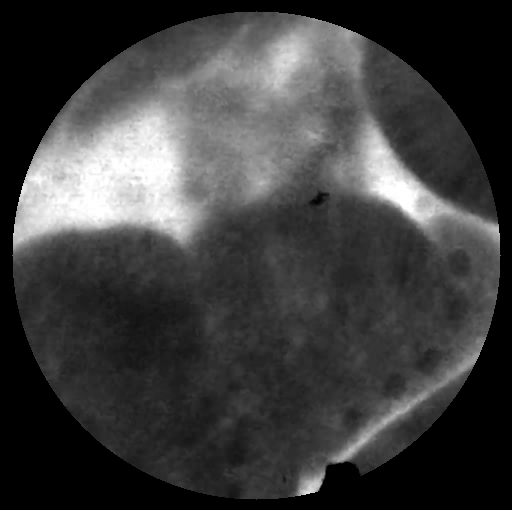

In [ ]:
display(Image(affected_img3))